# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

keywords are unexpanded, not using


In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -0.926419 -0.093369  0.0  0.879932 -0.560222  0.078616  2  0   7.406985   
1 -1.528828  0.534283  1.0  0.858199 -1.757963 -0.602252  1  1  12.374345   
2 -0.816458  2.318436  0.0  0.643900 -1.674629 -0.547364  3  0  -1.060650   
3 -2.019049  1.849708  1.0  0.316242 -0.061087  1.904006  0  0  20.853166   
4 -0.617022 -0.336734  1.0  0.681668 -0.693970 -1.125518  2  1  18.224985   

            y  
0   50.265798  
1   55.507420  
2   -7.454812  
3  110.930558  
4  129.927342  
True causal estimate is 7.695431349902705


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

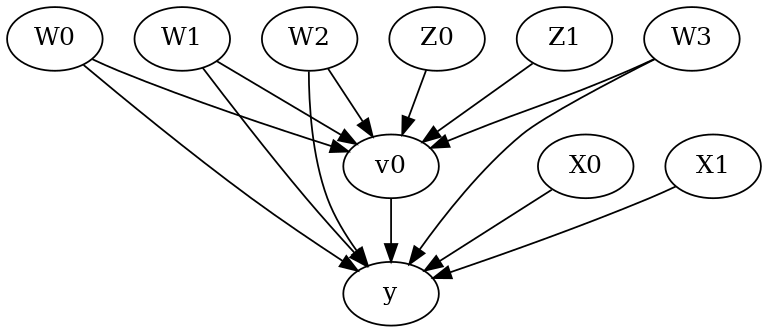

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['X0', 'X1']}


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W0+W3+W1+v0*X0+v0*X1
Target units: ate

## Estimate
Mean value: 7.695326892818904
### Conditional Estimates
__categorical__X0  __categorical__X1
(-4.383, -1.598]   (-3.606, -0.459]     -0.690864
                   (-0.459, 0.135]       0.761601
                   (0.135, 0.639]        1.835118
                   (0.639, 1.213]        2.978258
                   (1.213, 4.196]        4.654211
(-1.598, -0.975]   (-3.606, -0.459]      2.787863
                   (-0.459, 0.135]       4.477868
                   (0.135, 0.639]        5.437678
                   (0.639, 1.213]        6.592852
                   (1.213, 4.196]        8.23772

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W0+W3+W1 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 16.54778122584896
Effect estimates: [16.54792857 15.78397366 15.58495019 15.48253657 18.17555873 20.61811868
 19.92831664 12.14089447 17.25016535 17.65797599 12.85352589 18.96733515
 13.41160313 13.17304865 15.06011075 13.90522883 14.20900115 22.00481403
 16.68369652 19.70159705 16.39330145 15.60297632 13.85125734 14.6577894
 14.35205756 13.86320153 14.14439554 16.45468052 17.02388034 15.50025849
 15.90176611 18.59897638 20.14480557 23.68688716 14.17303968 15.19466714
 13.04193453 19.62982852 15.06906156 19.46952993 21.33942218 18.41302829
 13.996

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 7.695431349902705


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W0+W3+W1 | X0,X1
Target units: 

## Estimate
Mean value: 7.5982345887418035
Effect estimates: [ 5.91509581  4.66773491 11.05587767 ... 10.59300304  1.00937264
 10.9747507 ]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W0+W3+W1 | X0,X1
Target units: ate

## Estimate
Mean value: 7.57739035801775
Effect estimates: [ 5.91788464  4.68097943 10.9794753  ... 10.54480291  1.07903869
 10.90182469]
95.0% confidence interval: (array([ 5.888422  ,  4.62054716, 10.84981895, ..., 10.45993432,
        0.9448964 , 10.79246587]), array([ 6.00661129,  4.76784372, 11.22790922, ..., 10.80390582,
        1.22128083, 11.1218972 ]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[10.22609853 11.60595095 10.73237316 10.95627303 13.16369722 14.71765085
 15.47328674 13.98632886 11.87958621 12.97168452]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -0.590974 -0.635349  0.0  0.748229 -0.900756 -1.991189 -0.451101   
1    -0.272499 -0.003545  0.0  0.290927 -0.488014 -0.948287  0.810341   
2    -0.383655  0.479996  0.0  0.293194  1.431896 -0.662402 -0.358977   
3    -1.260664  0.019887  1.0  0.792089  0.529233 -1.974211  1.162460   
4    -0.748804 -2.421636  0.0  0.329359 -0.017794 -1.025304  0.353045   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -1.244039  0.365221  0.0  0.195187 -0.111887 -1.156934 -1.256416   
9996 -1.963880 -0.918364  1.0  0.772713 -0.487796 -1.752110 -0.137865   
9997  0.397109  1.418999  0.0  0.021866  0.336648 -0.671965 -0.288046   
9998 -0.319036  0.483690  0.0  0.669934 -2.092523  0.623726 -0.361809   
9999 -0.545824  0.337109  0.0  0.946218 -0.862995  1.598176 -0.538890   

            W3  v0  y  
0    -1.214641   0  0  
1     0.153451   1  1  
2     1.795667   1  1  
3    -0.545783   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W0+W3+W1 | X0,X1
Target units: ate

## Estimate
Mean value: 0.6509724481937553
Effect estimates: [0.54164745 0.61767769 0.63665556 ... 0.7836211  0.64403375 0.60950117]

True causal estimate is 0.4863


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-08-02 14:28:57.783871: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /__t/Python/3.10.5/x64/lib
2022-08-02 14:28:57.783909: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-08-02 14:28:59.104172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /__t/Python/3.10.5/x64/lib
2022-08-02 14:28:59.104210: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-02 14:28:59.104233: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (27539fa5fb08): /proc/driver/nvidia/version does not exist
2022-08-02 14:28:59.104469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 3:18 - loss: 80.3168

 35/313 [==>...........................] - ETA: 0s - loss: 27.9514  

 69/313 [=====>........................] - ETA: 0s - loss: 16.4452

103/313 [========>.....................] - ETA: 0s - loss: 12.3737

137/313 [============>.................] - ETA: 0s - loss: 10.2320

172/313 [===============>..............] - ETA: 0s - loss: 8.9003 

207/313 [==================>...........] - ETA: 0s - loss: 7.9993

241/313 [======================>.......] - ETA: 0s - loss: 7.3654

276/313 [=========================>....] - ETA: 0s - loss: 6.8520

311/313 [============================>.] - ETA: 0s - loss: 6.4505

313/313 [==============================] - 1s 1ms/step - loss: 6.4309


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 2.9496

 36/313 [==>...........................] - ETA: 0s - loss: 3.1582

 71/313 [=====>........................] - ETA: 0s - loss: 3.1495

105/313 [=========>....................] - ETA: 0s - loss: 3.1290

139/313 [============>.................] - ETA: 0s - loss: 3.1123

173/313 [===============>..............] - ETA: 0s - loss: 3.0960

208/313 [==================>...........] - ETA: 0s - loss: 3.0845

241/313 [======================>.......] - ETA: 0s - loss: 3.0756

275/313 [=========================>....] - ETA: 0s - loss: 3.0613

309/313 [============================>.] - ETA: 0s - loss: 3.0513

313/313 [==============================] - 0s 1ms/step - loss: 3.0506


Epoch 3/25


  1/313 [..............................] - ETA: 0s - loss: 2.8298

 36/313 [==>...........................] - ETA: 0s - loss: 2.8916

 71/313 [=====>........................] - ETA: 0s - loss: 2.8711

105/313 [=========>....................] - ETA: 0s - loss: 2.8817

140/313 [============>.................] - ETA: 0s - loss: 2.8839

175/313 [===============>..............] - ETA: 0s - loss: 2.8741

208/313 [==================>...........] - ETA: 0s - loss: 2.8679

242/313 [======================>.......] - ETA: 0s - loss: 2.8552

276/313 [=========================>....] - ETA: 0s - loss: 2.8496

310/313 [============================>.] - ETA: 0s - loss: 2.8448

313/313 [==============================] - 0s 1ms/step - loss: 2.8439


Epoch 4/25


  1/313 [..............................] - ETA: 0s - loss: 2.6848

 35/313 [==>...........................] - ETA: 0s - loss: 2.7649

 70/313 [=====>........................] - ETA: 0s - loss: 2.7471

105/313 [=========>....................] - ETA: 0s - loss: 2.7477

139/313 [============>.................] - ETA: 0s - loss: 2.7585

174/313 [===============>..............] - ETA: 0s - loss: 2.7670

209/313 [===================>..........] - ETA: 0s - loss: 2.7705

244/313 [======================>.......] - ETA: 0s - loss: 2.7727

278/313 [=========================>....] - ETA: 0s - loss: 2.7709

312/313 [============================>.] - ETA: 0s - loss: 2.7725

313/313 [==============================] - 0s 1ms/step - loss: 2.7742


Epoch 5/25


  1/313 [..............................] - ETA: 0s - loss: 2.7163

 35/313 [==>...........................] - ETA: 0s - loss: 2.7501

 70/313 [=====>........................] - ETA: 0s - loss: 2.7522

105/313 [=========>....................] - ETA: 0s - loss: 2.7511

139/313 [============>.................] - ETA: 0s - loss: 2.7519

174/313 [===============>..............] - ETA: 0s - loss: 2.7408

209/313 [===================>..........] - ETA: 0s - loss: 2.7428

245/313 [======================>.......] - ETA: 0s - loss: 2.7447

281/313 [=========================>....] - ETA: 0s - loss: 2.7344

313/313 [==============================] - 0s 1ms/step - loss: 2.7382


Epoch 6/25


  1/313 [..............................] - ETA: 0s - loss: 2.5120

 35/313 [==>...........................] - ETA: 0s - loss: 2.7576

 70/313 [=====>........................] - ETA: 0s - loss: 2.7380

105/313 [=========>....................] - ETA: 0s - loss: 2.7335

139/313 [============>.................] - ETA: 0s - loss: 2.7303

174/313 [===============>..............] - ETA: 0s - loss: 2.7226

208/313 [==================>...........] - ETA: 0s - loss: 2.7235

242/313 [======================>.......] - ETA: 0s - loss: 2.7218

277/313 [=========================>....] - ETA: 0s - loss: 2.7250

311/313 [============================>.] - ETA: 0s - loss: 2.7213

313/313 [==============================] - 0s 1ms/step - loss: 2.7216


Epoch 7/25


  1/313 [..............................] - ETA: 0s - loss: 2.7751

 37/313 [==>...........................] - ETA: 0s - loss: 2.6955

 72/313 [=====>........................] - ETA: 0s - loss: 2.7134

106/313 [=========>....................] - ETA: 0s - loss: 2.7015

141/313 [============>.................] - ETA: 0s - loss: 2.6966

176/313 [===============>..............] - ETA: 0s - loss: 2.7032

211/313 [===================>..........] - ETA: 0s - loss: 2.6990

245/313 [======================>.......] - ETA: 0s - loss: 2.6995

279/313 [=========================>....] - ETA: 0s - loss: 2.7032

313/313 [==============================] - 0s 1ms/step - loss: 2.7012


Epoch 8/25


  1/313 [..............................] - ETA: 0s - loss: 3.1967

 36/313 [==>...........................] - ETA: 0s - loss: 2.6726

 71/313 [=====>........................] - ETA: 0s - loss: 2.6723

106/313 [=========>....................] - ETA: 0s - loss: 2.6709

140/313 [============>.................] - ETA: 0s - loss: 2.6799

175/313 [===============>..............] - ETA: 0s - loss: 2.6834

210/313 [===================>..........] - ETA: 0s - loss: 2.6861

244/313 [======================>.......] - ETA: 0s - loss: 2.6886

279/313 [=========================>....] - ETA: 0s - loss: 2.6874

313/313 [==============================] - ETA: 0s - loss: 2.6858

313/313 [==============================] - 0s 1ms/step - loss: 2.6858


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 2.5455

 36/313 [==>...........................] - ETA: 0s - loss: 2.6676

 71/313 [=====>........................] - ETA: 0s - loss: 2.6665

106/313 [=========>....................] - ETA: 0s - loss: 2.6906

141/313 [============>.................] - ETA: 0s - loss: 2.6818

175/313 [===============>..............] - ETA: 0s - loss: 2.6769

210/313 [===================>..........] - ETA: 0s - loss: 2.6795

245/313 [======================>.......] - ETA: 0s - loss: 2.6765

279/313 [=========================>....] - ETA: 0s - loss: 2.6771

313/313 [==============================] - 0s 1ms/step - loss: 2.6812


Epoch 10/25


  1/313 [..............................] - ETA: 0s - loss: 2.6945

 36/313 [==>...........................] - ETA: 0s - loss: 2.6728

 70/313 [=====>........................] - ETA: 0s - loss: 2.6767

105/313 [=========>....................] - ETA: 0s - loss: 2.6896

139/313 [============>.................] - ETA: 0s - loss: 2.6738

174/313 [===============>..............] - ETA: 0s - loss: 2.6788

210/313 [===================>..........] - ETA: 0s - loss: 2.6812

246/313 [======================>.......] - ETA: 0s - loss: 2.6747

281/313 [=========================>....] - ETA: 0s - loss: 2.6697

313/313 [==============================] - 0s 1ms/step - loss: 2.6708


Epoch 11/25


  1/313 [..............................] - ETA: 0s - loss: 2.6880

 35/313 [==>...........................] - ETA: 0s - loss: 2.6428

 70/313 [=====>........................] - ETA: 0s - loss: 2.6455

105/313 [=========>....................] - ETA: 0s - loss: 2.6442

140/313 [============>.................] - ETA: 0s - loss: 2.6442

175/313 [===============>..............] - ETA: 0s - loss: 2.6457

209/313 [===================>..........] - ETA: 0s - loss: 2.6529

244/313 [======================>.......] - ETA: 0s - loss: 2.6559

279/313 [=========================>....] - ETA: 0s - loss: 2.6557

313/313 [==============================] - ETA: 0s - loss: 2.6545

313/313 [==============================] - 0s 1ms/step - loss: 2.6545


Epoch 12/25


  1/313 [..............................] - ETA: 0s - loss: 2.5471

 36/313 [==>...........................] - ETA: 0s - loss: 2.6875

 71/313 [=====>........................] - ETA: 0s - loss: 2.6812

105/313 [=========>....................] - ETA: 0s - loss: 2.6723

139/313 [============>.................] - ETA: 0s - loss: 2.6681

173/313 [===============>..............] - ETA: 0s - loss: 2.6637

208/313 [==================>...........] - ETA: 0s - loss: 2.6596

243/313 [======================>.......] - ETA: 0s - loss: 2.6630

278/313 [=========================>....] - ETA: 0s - loss: 2.6606

313/313 [==============================] - ETA: 0s - loss: 2.6572

313/313 [==============================] - 0s 1ms/step - loss: 2.6572


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 2.5422

 33/313 [==>...........................] - ETA: 0s - loss: 2.6828

 68/313 [=====>........................] - ETA: 0s - loss: 2.6473

103/313 [========>.....................] - ETA: 0s - loss: 2.6473

137/313 [============>.................] - ETA: 0s - loss: 2.6514

171/313 [===============>..............] - ETA: 0s - loss: 2.6439

206/313 [==================>...........] - ETA: 0s - loss: 2.6488

241/313 [======================>.......] - ETA: 0s - loss: 2.6476

275/313 [=========================>....] - ETA: 0s - loss: 2.6479

310/313 [============================>.] - ETA: 0s - loss: 2.6469

313/313 [==============================] - 0s 1ms/step - loss: 2.6482


Epoch 14/25


  1/313 [..............................] - ETA: 0s - loss: 2.5013

 36/313 [==>...........................] - ETA: 0s - loss: 2.7039

 71/313 [=====>........................] - ETA: 0s - loss: 2.6815

106/313 [=========>....................] - ETA: 0s - loss: 2.6648

140/313 [============>.................] - ETA: 0s - loss: 2.6619

175/313 [===============>..............] - ETA: 0s - loss: 2.6582

210/313 [===================>..........] - ETA: 0s - loss: 2.6581

245/313 [======================>.......] - ETA: 0s - loss: 2.6543

280/313 [=========================>....] - ETA: 0s - loss: 2.6501

313/313 [==============================] - 0s 1ms/step - loss: 2.6482


Epoch 15/25


  1/313 [..............................] - ETA: 0s - loss: 2.6330

 36/313 [==>...........................] - ETA: 0s - loss: 2.6509

 71/313 [=====>........................] - ETA: 0s - loss: 2.6390

106/313 [=========>....................] - ETA: 0s - loss: 2.6343

140/313 [============>.................] - ETA: 0s - loss: 2.6376

174/313 [===============>..............] - ETA: 0s - loss: 2.6411

209/313 [===================>..........] - ETA: 0s - loss: 2.6381

244/313 [======================>.......] - ETA: 0s - loss: 2.6401

279/313 [=========================>....] - ETA: 0s - loss: 2.6330

313/313 [==============================] - 0s 1ms/step - loss: 2.6357


Epoch 16/25


  1/313 [..............................] - ETA: 0s - loss: 2.6485

 36/313 [==>...........................] - ETA: 0s - loss: 2.6050

 71/313 [=====>........................] - ETA: 0s - loss: 2.6214

106/313 [=========>....................] - ETA: 0s - loss: 2.6239

140/313 [============>.................] - ETA: 0s - loss: 2.6301

175/313 [===============>..............] - ETA: 0s - loss: 2.6289

209/313 [===================>..........] - ETA: 0s - loss: 2.6254

242/313 [======================>.......] - ETA: 0s - loss: 2.6279

276/313 [=========================>....] - ETA: 0s - loss: 2.6316

310/313 [============================>.] - ETA: 0s - loss: 2.6323

313/313 [==============================] - 0s 1ms/step - loss: 2.6329


Epoch 17/25


  1/313 [..............................] - ETA: 0s - loss: 2.8618

 36/313 [==>...........................] - ETA: 0s - loss: 2.6747

 71/313 [=====>........................] - ETA: 0s - loss: 2.6484

106/313 [=========>....................] - ETA: 0s - loss: 2.6498

140/313 [============>.................] - ETA: 0s - loss: 2.6395

174/313 [===============>..............] - ETA: 0s - loss: 2.6377

208/313 [==================>...........] - ETA: 0s - loss: 2.6397

242/313 [======================>.......] - ETA: 0s - loss: 2.6341

277/313 [=========================>....] - ETA: 0s - loss: 2.6304

312/313 [============================>.] - ETA: 0s - loss: 2.6288

313/313 [==============================] - 0s 1ms/step - loss: 2.6287


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 2.5399

 36/313 [==>...........................] - ETA: 0s - loss: 2.6305

 71/313 [=====>........................] - ETA: 0s - loss: 2.6122

106/313 [=========>....................] - ETA: 0s - loss: 2.6085

140/313 [============>.................] - ETA: 0s - loss: 2.6111

174/313 [===============>..............] - ETA: 0s - loss: 2.6080

208/313 [==================>...........] - ETA: 0s - loss: 2.6096

242/313 [======================>.......] - ETA: 0s - loss: 2.6139

276/313 [=========================>....] - ETA: 0s - loss: 2.6169

310/313 [============================>.] - ETA: 0s - loss: 2.6185

313/313 [==============================] - 0s 1ms/step - loss: 2.6183


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 2.5326

 35/313 [==>...........................] - ETA: 0s - loss: 2.6479

 69/313 [=====>........................] - ETA: 0s - loss: 2.6222

103/313 [========>.....................] - ETA: 0s - loss: 2.6148

137/313 [============>.................] - ETA: 0s - loss: 2.6075

171/313 [===============>..............] - ETA: 0s - loss: 2.6082

205/313 [==================>...........] - ETA: 0s - loss: 2.6100

240/313 [======================>.......] - ETA: 0s - loss: 2.6087

273/313 [=========================>....] - ETA: 0s - loss: 2.6076

308/313 [============================>.] - ETA: 0s - loss: 2.6136

313/313 [==============================] - 0s 1ms/step - loss: 2.6142


Epoch 20/25


  1/313 [..............................] - ETA: 0s - loss: 2.5866

 36/313 [==>...........................] - ETA: 0s - loss: 2.5966

 71/313 [=====>........................] - ETA: 0s - loss: 2.6016

106/313 [=========>....................] - ETA: 0s - loss: 2.6163

140/313 [============>.................] - ETA: 0s - loss: 2.6157

175/313 [===============>..............] - ETA: 0s - loss: 2.6082

210/313 [===================>..........] - ETA: 0s - loss: 2.6110

244/313 [======================>.......] - ETA: 0s - loss: 2.6092

278/313 [=========================>....] - ETA: 0s - loss: 2.6094

312/313 [============================>.] - ETA: 0s - loss: 2.6083

313/313 [==============================] - 0s 1ms/step - loss: 2.6077


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 2.7112

 36/313 [==>...........................] - ETA: 0s - loss: 2.6266

 70/313 [=====>........................] - ETA: 0s - loss: 2.6133

104/313 [========>.....................] - ETA: 0s - loss: 2.6100

138/313 [============>.................] - ETA: 0s - loss: 2.6087

172/313 [===============>..............] - ETA: 0s - loss: 2.6032

206/313 [==================>...........] - ETA: 0s - loss: 2.6058

240/313 [======================>.......] - ETA: 0s - loss: 2.6027

274/313 [=========================>....] - ETA: 0s - loss: 2.6088

308/313 [============================>.] - ETA: 0s - loss: 2.6056

313/313 [==============================] - 0s 1ms/step - loss: 2.6064


Epoch 22/25


  1/313 [..............................] - ETA: 0s - loss: 2.5131

 36/313 [==>...........................] - ETA: 0s - loss: 2.6007

 71/313 [=====>........................] - ETA: 0s - loss: 2.5952

106/313 [=========>....................] - ETA: 0s - loss: 2.5722

140/313 [============>.................] - ETA: 0s - loss: 2.5789

175/313 [===============>..............] - ETA: 0s - loss: 2.5814

210/313 [===================>..........] - ETA: 0s - loss: 2.5844

245/313 [======================>.......] - ETA: 0s - loss: 2.5915

279/313 [=========================>....] - ETA: 0s - loss: 2.5943

313/313 [==============================] - ETA: 0s - loss: 2.5951

313/313 [==============================] - 0s 1ms/step - loss: 2.5951


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 2.3654

 35/313 [==>...........................] - ETA: 0s - loss: 2.6080

 70/313 [=====>........................] - ETA: 0s - loss: 2.5947

105/313 [=========>....................] - ETA: 0s - loss: 2.6055

140/313 [============>.................] - ETA: 0s - loss: 2.6087

175/313 [===============>..............] - ETA: 0s - loss: 2.6029

209/313 [===================>..........] - ETA: 0s - loss: 2.5976

243/313 [======================>.......] - ETA: 0s - loss: 2.5978

277/313 [=========================>....] - ETA: 0s - loss: 2.5972

312/313 [============================>.] - ETA: 0s - loss: 2.5982

313/313 [==============================] - 0s 1ms/step - loss: 2.5981


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 2.5331

 35/313 [==>...........................] - ETA: 0s - loss: 2.6049

 69/313 [=====>........................] - ETA: 0s - loss: 2.6062

103/313 [========>.....................] - ETA: 0s - loss: 2.5985

138/313 [============>.................] - ETA: 0s - loss: 2.6018

173/313 [===============>..............] - ETA: 0s - loss: 2.5985

208/313 [==================>...........] - ETA: 0s - loss: 2.5938

243/313 [======================>.......] - ETA: 0s - loss: 2.5924

278/313 [=========================>....] - ETA: 0s - loss: 2.5977

312/313 [============================>.] - ETA: 0s - loss: 2.5971

313/313 [==============================] - 0s 1ms/step - loss: 2.5965


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 2.5249

 35/313 [==>...........................] - ETA: 0s - loss: 2.5734

 69/313 [=====>........................] - ETA: 0s - loss: 2.5883

103/313 [========>.....................] - ETA: 0s - loss: 2.5932

138/313 [============>.................] - ETA: 0s - loss: 2.5868

172/313 [===============>..............] - ETA: 0s - loss: 2.5882

206/313 [==================>...........] - ETA: 0s - loss: 2.5939

240/313 [======================>.......] - ETA: 0s - loss: 2.5936

275/313 [=========================>....] - ETA: 0s - loss: 2.5948

310/313 [============================>.] - ETA: 0s - loss: 2.5979

313/313 [==============================] - 0s 1ms/step - loss: 2.5978


Epoch 1/25


  1/313 [..............................] - ETA: 3:50 - loss: 29865.0625

 28/313 [=>............................] - ETA: 0s - loss: 21381.6191  

 55/313 [====>.........................] - ETA: 0s - loss: 18742.1621

 83/313 [======>.......................] - ETA: 0s - loss: 16917.0449

111/313 [=========>....................] - ETA: 0s - loss: 15698.6523

140/313 [============>.................] - ETA: 0s - loss: 15154.5156

168/313 [===============>..............] - ETA: 0s - loss: 14465.8770

196/313 [=================>............] - ETA: 0s - loss: 13969.3418

224/313 [====================>.........] - ETA: 0s - loss: 13549.5322

252/313 [=======================>......] - ETA: 0s - loss: 13199.9219

280/313 [=========================>....] - ETA: 0s - loss: 12820.4639

308/313 [============================>.] - ETA: 0s - loss: 12501.9990

313/313 [==============================] - 1s 2ms/step - loss: 12421.8418


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 11270.0625

 29/313 [=>............................] - ETA: 0s - loss: 8934.4717 

 55/313 [====>.........................] - ETA: 0s - loss: 8899.4561

 82/313 [======>.......................] - ETA: 0s - loss: 8616.2520

110/313 [=========>....................] - ETA: 0s - loss: 8751.8408

138/313 [============>.................] - ETA: 0s - loss: 8533.5742

166/313 [==============>...............] - ETA: 0s - loss: 8539.7422

194/313 [=================>............] - ETA: 0s - loss: 8505.9131

222/313 [====================>.........] - ETA: 0s - loss: 8487.7910

250/313 [======================>.......] - ETA: 0s - loss: 8433.3750

278/313 [=========================>....] - ETA: 0s - loss: 8382.9902

306/313 [============================>.] - ETA: 0s - loss: 8390.7197

313/313 [==============================] - 1s 2ms/step - loss: 8388.5449


Epoch 3/25


  1/313 [..............................] - ETA: 0s - loss: 4147.5283

 29/313 [=>............................] - ETA: 0s - loss: 7975.8545

 57/313 [====>.........................] - ETA: 0s - loss: 7823.8740

 86/313 [=======>......................] - ETA: 0s - loss: 7981.3730

114/313 [=========>....................] - ETA: 0s - loss: 8174.5454

143/313 [============>.................] - ETA: 0s - loss: 8045.8208

172/313 [===============>..............] - ETA: 0s - loss: 8067.0103

201/313 [==================>...........] - ETA: 0s - loss: 8006.8340

230/313 [=====================>........] - ETA: 0s - loss: 8037.4678

259/313 [=======================>......] - ETA: 0s - loss: 8044.4165

289/313 [==========================>...] - ETA: 0s - loss: 8087.0293

313/313 [==============================] - 1s 2ms/step - loss: 8067.0957


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 5613.2671

 30/313 [=>............................] - ETA: 0s - loss: 8334.2812

 59/313 [====>.........................] - ETA: 0s - loss: 8441.1289

 89/313 [=======>......................] - ETA: 0s - loss: 8347.6475

119/313 [==========>...................] - ETA: 0s - loss: 8081.7651

148/313 [=============>................] - ETA: 0s - loss: 7914.7583

177/313 [===============>..............] - ETA: 0s - loss: 8088.7739

206/313 [==================>...........] - ETA: 0s - loss: 8019.0498

235/313 [=====================>........] - ETA: 0s - loss: 8176.9385

264/313 [========================>.....] - ETA: 0s - loss: 8104.1431

294/313 [===========================>..] - ETA: 0s - loss: 8065.9951

313/313 [==============================] - 1s 2ms/step - loss: 8068.1108


Epoch 5/25


  1/313 [..............................] - ETA: 0s - loss: 15953.4346

 30/313 [=>............................] - ETA: 0s - loss: 8419.8652 

 60/313 [====>.........................] - ETA: 0s - loss: 8453.6318

 90/313 [=======>......................] - ETA: 0s - loss: 8647.4326

119/313 [==========>...................] - ETA: 0s - loss: 8815.2627

148/313 [=============>................] - ETA: 0s - loss: 8581.1562

175/313 [===============>..............] - ETA: 0s - loss: 8518.5947

203/313 [==================>...........] - ETA: 0s - loss: 8399.9170

230/313 [=====================>........] - ETA: 0s - loss: 8390.6982

258/313 [=======================>......] - ETA: 0s - loss: 8298.9736

286/313 [==========================>...] - ETA: 0s - loss: 8172.6738

313/313 [==============================] - 1s 2ms/step - loss: 8089.3042


Epoch 6/25


  1/313 [..............................] - ETA: 0s - loss: 7226.9458

 30/313 [=>............................] - ETA: 0s - loss: 8238.6162

 60/313 [====>.........................] - ETA: 0s - loss: 7782.2212

 89/313 [=======>......................] - ETA: 0s - loss: 8015.8047

118/313 [==========>...................] - ETA: 0s - loss: 7989.0615

146/313 [============>.................] - ETA: 0s - loss: 8070.2441

173/313 [===============>..............] - ETA: 0s - loss: 8092.7158

202/313 [==================>...........] - ETA: 0s - loss: 8040.3501

231/313 [=====================>........] - ETA: 0s - loss: 8067.8311

260/313 [=======================>......] - ETA: 0s - loss: 8077.2373

289/313 [==========================>...] - ETA: 0s - loss: 8032.8877

313/313 [==============================] - 1s 2ms/step - loss: 8016.7715


Epoch 7/25


  1/313 [..............................] - ETA: 0s - loss: 9823.8291

 29/313 [=>............................] - ETA: 0s - loss: 8543.8418

 58/313 [====>.........................] - ETA: 0s - loss: 7952.0054

 87/313 [=======>......................] - ETA: 0s - loss: 7892.9463

116/313 [==========>...................] - ETA: 0s - loss: 7953.4790

145/313 [============>.................] - ETA: 0s - loss: 7832.1929

174/313 [===============>..............] - ETA: 0s - loss: 7821.2939

203/313 [==================>...........] - ETA: 0s - loss: 7840.1768

232/313 [=====================>........] - ETA: 0s - loss: 7868.7998

261/313 [========================>.....] - ETA: 0s - loss: 7964.3677

289/313 [==========================>...] - ETA: 0s - loss: 7881.9238

313/313 [==============================] - 1s 2ms/step - loss: 7914.3882


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 5452.9424

 28/313 [=>............................] - ETA: 0s - loss: 7355.7329

 55/313 [====>.........................] - ETA: 0s - loss: 7133.0518

 84/313 [=======>......................] - ETA: 0s - loss: 7404.4761

113/313 [=========>....................] - ETA: 0s - loss: 7657.7202

142/313 [============>.................] - ETA: 0s - loss: 7677.2114

171/313 [===============>..............] - ETA: 0s - loss: 7545.1562

200/313 [==================>...........] - ETA: 0s - loss: 7668.4302

229/313 [====================>.........] - ETA: 0s - loss: 7830.0435

258/313 [=======================>......] - ETA: 0s - loss: 7822.9619

287/313 [==========================>...] - ETA: 0s - loss: 7905.3970

313/313 [==============================] - 1s 2ms/step - loss: 7941.8809


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 7650.6406

 29/313 [=>............................] - ETA: 0s - loss: 7420.3906

 57/313 [====>.........................] - ETA: 0s - loss: 7735.6460

 87/313 [=======>......................] - ETA: 0s - loss: 7638.5059

116/313 [==========>...................] - ETA: 0s - loss: 7792.8975

145/313 [============>.................] - ETA: 0s - loss: 7789.8838

174/313 [===============>..............] - ETA: 0s - loss: 7829.4741

203/313 [==================>...........] - ETA: 0s - loss: 7844.3628

232/313 [=====================>........] - ETA: 0s - loss: 7777.2920

261/313 [========================>.....] - ETA: 0s - loss: 7864.6938

290/313 [==========================>...] - ETA: 0s - loss: 7845.4653

313/313 [==============================] - 1s 2ms/step - loss: 7864.1533


Epoch 10/25


  1/313 [..............................] - ETA: 0s - loss: 6315.3530

 30/313 [=>............................] - ETA: 0s - loss: 8639.9199

 58/313 [====>.........................] - ETA: 0s - loss: 8109.3105

 87/313 [=======>......................] - ETA: 0s - loss: 8137.3247

117/313 [==========>...................] - ETA: 0s - loss: 7893.7456

146/313 [============>.................] - ETA: 0s - loss: 7838.3149

175/313 [===============>..............] - ETA: 0s - loss: 7778.3872

204/313 [==================>...........] - ETA: 0s - loss: 7730.2988

233/313 [=====================>........] - ETA: 0s - loss: 7862.1514

262/313 [========================>.....] - ETA: 0s - loss: 7888.7788

291/313 [==========================>...] - ETA: 0s - loss: 7851.4341

313/313 [==============================] - 1s 2ms/step - loss: 7842.9487


Epoch 11/25


  1/313 [..............................] - ETA: 0s - loss: 5275.9688

 29/313 [=>............................] - ETA: 0s - loss: 7948.8638

 57/313 [====>.........................] - ETA: 0s - loss: 8383.6797

 85/313 [=======>......................] - ETA: 0s - loss: 8169.4722

113/313 [=========>....................] - ETA: 0s - loss: 8120.2095

141/313 [============>.................] - ETA: 0s - loss: 8025.2988

169/313 [===============>..............] - ETA: 0s - loss: 7894.3423

197/313 [=================>............] - ETA: 0s - loss: 7881.4697

225/313 [====================>.........] - ETA: 0s - loss: 7844.2412

252/313 [=======================>......] - ETA: 0s - loss: 7777.0566

280/313 [=========================>....] - ETA: 0s - loss: 7782.7778

308/313 [============================>.] - ETA: 0s - loss: 7852.8232

313/313 [==============================] - 1s 2ms/step - loss: 7829.6831


Epoch 12/25


  1/313 [..............................] - ETA: 0s - loss: 8065.9619

 29/313 [=>............................] - ETA: 0s - loss: 7832.0239

 57/313 [====>.........................] - ETA: 0s - loss: 7696.6377

 85/313 [=======>......................] - ETA: 0s - loss: 7644.1538

113/313 [=========>....................] - ETA: 0s - loss: 7383.9858

140/313 [============>.................] - ETA: 0s - loss: 7433.2178

168/313 [===============>..............] - ETA: 0s - loss: 7548.3398

196/313 [=================>............] - ETA: 0s - loss: 7577.1348

225/313 [====================>.........] - ETA: 0s - loss: 7842.8965

253/313 [=======================>......] - ETA: 0s - loss: 7805.1318

280/313 [=========================>....] - ETA: 0s - loss: 7813.3569

307/313 [============================>.] - ETA: 0s - loss: 7834.6401

313/313 [==============================] - 1s 2ms/step - loss: 7783.1484


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 5879.2637

 29/313 [=>............................] - ETA: 0s - loss: 8279.7148

 57/313 [====>.........................] - ETA: 0s - loss: 8201.1953

 86/313 [=======>......................] - ETA: 0s - loss: 8051.4956

114/313 [=========>....................] - ETA: 0s - loss: 7960.4536

143/313 [============>.................] - ETA: 0s - loss: 7997.4272

172/313 [===============>..............] - ETA: 0s - loss: 7870.7559

201/313 [==================>...........] - ETA: 0s - loss: 7819.9302

230/313 [=====================>........] - ETA: 0s - loss: 7688.1533

258/313 [=======================>......] - ETA: 0s - loss: 7862.8535

286/313 [==========================>...] - ETA: 0s - loss: 7829.3550

313/313 [==============================] - 1s 2ms/step - loss: 7808.4985


Epoch 14/25


  1/313 [..............................] - ETA: 0s - loss: 6745.9736

 29/313 [=>............................] - ETA: 0s - loss: 9276.0820

 56/313 [====>.........................] - ETA: 0s - loss: 8204.7412

 84/313 [=======>......................] - ETA: 0s - loss: 8454.1289

112/313 [=========>....................] - ETA: 0s - loss: 8167.8589

140/313 [============>.................] - ETA: 0s - loss: 8457.8955

168/313 [===============>..............] - ETA: 0s - loss: 8240.4219

196/313 [=================>............] - ETA: 0s - loss: 8233.1309

224/313 [====================>.........] - ETA: 0s - loss: 8297.3105

252/313 [=======================>......] - ETA: 0s - loss: 8234.6484

280/313 [=========================>....] - ETA: 0s - loss: 8180.8418

308/313 [============================>.] - ETA: 0s - loss: 8032.9570

313/313 [==============================] - 1s 2ms/step - loss: 8016.6831


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 4492.4355

 30/313 [=>............................] - ETA: 0s - loss: 8380.6924

 58/313 [====>.........................] - ETA: 0s - loss: 7916.1230

 86/313 [=======>......................] - ETA: 0s - loss: 8095.0293

115/313 [==========>...................] - ETA: 0s - loss: 8183.8174

142/313 [============>.................] - ETA: 0s - loss: 8077.3521

169/313 [===============>..............] - ETA: 0s - loss: 7896.6030

197/313 [=================>............] - ETA: 0s - loss: 7824.7217

225/313 [====================>.........] - ETA: 0s - loss: 7845.3618

255/313 [=======================>......] - ETA: 0s - loss: 7901.7832

285/313 [==========================>...] - ETA: 0s - loss: 7908.5649

313/313 [==============================] - 1s 2ms/step - loss: 7836.1206


Epoch 16/25


  1/313 [..............................] - ETA: 0s - loss: 8988.8535

 31/313 [=>............................] - ETA: 0s - loss: 7739.0396

 60/313 [====>.........................] - ETA: 0s - loss: 7828.5093

 89/313 [=======>......................] - ETA: 0s - loss: 7995.5708

118/313 [==========>...................] - ETA: 0s - loss: 7850.1396

147/313 [=============>................] - ETA: 0s - loss: 7656.9185

176/313 [===============>..............] - ETA: 0s - loss: 7660.4604

205/313 [==================>...........] - ETA: 0s - loss: 7757.7056

234/313 [=====================>........] - ETA: 0s - loss: 7778.6230

263/313 [========================>.....] - ETA: 0s - loss: 7894.6016

292/313 [==========================>...] - ETA: 0s - loss: 7850.8442

313/313 [==============================] - 1s 2ms/step - loss: 7802.7061


Epoch 17/25


  1/313 [..............................] - ETA: 0s - loss: 10734.6934

 31/313 [=>............................] - ETA: 0s - loss: 8002.9502 

 60/313 [====>.........................] - ETA: 0s - loss: 7985.7041

 90/313 [=======>......................] - ETA: 0s - loss: 7995.7119

120/313 [==========>...................] - ETA: 0s - loss: 7872.3828

149/313 [=============>................] - ETA: 0s - loss: 7993.6763

178/313 [================>.............] - ETA: 0s - loss: 7913.1655

206/313 [==================>...........] - ETA: 0s - loss: 7928.1455

234/313 [=====================>........] - ETA: 0s - loss: 7965.9561

262/313 [========================>.....] - ETA: 0s - loss: 7905.6973

290/313 [==========================>...] - ETA: 0s - loss: 7870.0415

313/313 [==============================] - 1s 2ms/step - loss: 7821.8394


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 7526.8418

 29/313 [=>............................] - ETA: 0s - loss: 7763.4688

 57/313 [====>.........................] - ETA: 0s - loss: 8129.5923

 85/313 [=======>......................] - ETA: 0s - loss: 8028.4419

113/313 [=========>....................] - ETA: 0s - loss: 7992.0532

141/313 [============>.................] - ETA: 0s - loss: 8074.0479

169/313 [===============>..............] - ETA: 0s - loss: 8087.6426

197/313 [=================>............] - ETA: 0s - loss: 7978.3354

224/313 [====================>.........] - ETA: 0s - loss: 7998.7334

252/313 [=======================>......] - ETA: 0s - loss: 7919.1284

280/313 [=========================>....] - ETA: 0s - loss: 7903.3848

308/313 [============================>.] - ETA: 0s - loss: 7862.5332

313/313 [==============================] - 1s 2ms/step - loss: 7852.7925


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 4730.1797

 29/313 [=>............................] - ETA: 0s - loss: 8030.8247

 57/313 [====>.........................] - ETA: 0s - loss: 7929.0820

 85/313 [=======>......................] - ETA: 0s - loss: 8021.8135

113/313 [=========>....................] - ETA: 0s - loss: 8066.9346

141/313 [============>.................] - ETA: 0s - loss: 7869.0215

170/313 [===============>..............] - ETA: 0s - loss: 7916.5483

199/313 [==================>...........] - ETA: 0s - loss: 7854.0879

227/313 [====================>.........] - ETA: 0s - loss: 7919.7539

255/313 [=======================>......] - ETA: 0s - loss: 7884.1118

282/313 [==========================>...] - ETA: 0s - loss: 7841.1851

310/313 [============================>.] - ETA: 0s - loss: 7816.6919

313/313 [==============================] - 1s 2ms/step - loss: 7806.8652


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 11779.4678

 29/313 [=>............................] - ETA: 0s - loss: 7403.5552 

 58/313 [====>.........................] - ETA: 0s - loss: 8202.2012

 87/313 [=======>......................] - ETA: 0s - loss: 7810.9858

115/313 [==========>...................] - ETA: 0s - loss: 7825.0010

143/313 [============>.................] - ETA: 0s - loss: 7647.9229

171/313 [===============>..............] - ETA: 0s - loss: 7764.6001

198/313 [=================>............] - ETA: 0s - loss: 7788.5820

226/313 [====================>.........] - ETA: 0s - loss: 7863.3379

253/313 [=======================>......] - ETA: 0s - loss: 7843.3013

282/313 [==========================>...] - ETA: 0s - loss: 7840.0176

309/313 [============================>.] - ETA: 0s - loss: 7848.1636

313/313 [==============================] - 1s 2ms/step - loss: 7848.2349


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 6482.3330

 29/313 [=>............................] - ETA: 0s - loss: 7286.8311

 58/313 [====>.........................] - ETA: 0s - loss: 7425.3374

 86/313 [=======>......................] - ETA: 0s - loss: 7808.3687

112/313 [=========>....................] - ETA: 0s - loss: 7924.8955

141/313 [============>.................] - ETA: 0s - loss: 8058.2812

170/313 [===============>..............] - ETA: 0s - loss: 8242.2871

199/313 [==================>...........] - ETA: 0s - loss: 8090.8687

228/313 [====================>.........] - ETA: 0s - loss: 8061.7910

256/313 [=======================>......] - ETA: 0s - loss: 7891.4360

284/313 [==========================>...] - ETA: 0s - loss: 7870.0767

312/313 [============================>.] - ETA: 0s - loss: 7862.2251

313/313 [==============================] - 1s 2ms/step - loss: 7862.9771


Epoch 22/25


  1/313 [..............................] - ETA: 0s - loss: 5808.3789

 30/313 [=>............................] - ETA: 0s - loss: 8014.8022

 59/313 [====>.........................] - ETA: 0s - loss: 7685.4399

 88/313 [=======>......................] - ETA: 0s - loss: 7547.1123

117/313 [==========>...................] - ETA: 0s - loss: 7748.1211

146/313 [============>.................] - ETA: 0s - loss: 7623.3486

175/313 [===============>..............] - ETA: 0s - loss: 7599.6221

204/313 [==================>...........] - ETA: 0s - loss: 7598.0410

233/313 [=====================>........] - ETA: 0s - loss: 7678.7358

261/313 [========================>.....] - ETA: 0s - loss: 7785.4038

289/313 [==========================>...] - ETA: 0s - loss: 7774.9688

313/313 [==============================] - 1s 2ms/step - loss: 7807.9180


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 9064.5977

 30/313 [=>............................] - ETA: 0s - loss: 7685.1226

 59/313 [====>.........................] - ETA: 0s - loss: 7823.7739

 88/313 [=======>......................] - ETA: 0s - loss: 7611.5620

117/313 [==========>...................] - ETA: 0s - loss: 7584.0640

146/313 [============>.................] - ETA: 0s - loss: 7529.3125

174/313 [===============>..............] - ETA: 0s - loss: 7553.2729

202/313 [==================>...........] - ETA: 0s - loss: 7599.1621

231/313 [=====================>........] - ETA: 0s - loss: 7720.6821

260/313 [=======================>......] - ETA: 0s - loss: 7811.4790

289/313 [==========================>...] - ETA: 0s - loss: 7879.9126

313/313 [==============================] - 1s 2ms/step - loss: 7923.6069


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 4306.5088

 30/313 [=>............................] - ETA: 0s - loss: 8239.8027

 58/313 [====>.........................] - ETA: 0s - loss: 7811.8438

 87/313 [=======>......................] - ETA: 0s - loss: 7481.6826

116/313 [==========>...................] - ETA: 0s - loss: 7672.2437

144/313 [============>.................] - ETA: 0s - loss: 7721.6899

173/313 [===============>..............] - ETA: 0s - loss: 7784.6885

202/313 [==================>...........] - ETA: 0s - loss: 7785.2710

231/313 [=====================>........] - ETA: 0s - loss: 7829.4004

261/313 [========================>.....] - ETA: 0s - loss: 7745.0479

290/313 [==========================>...] - ETA: 0s - loss: 7759.3008

313/313 [==============================] - 1s 2ms/step - loss: 7783.7539


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 7788.8701

 25/313 [=>............................] - ETA: 0s - loss: 7826.9536

 53/313 [====>.........................] - ETA: 0s - loss: 7812.1953

 81/313 [======>.......................] - ETA: 0s - loss: 7765.8789

109/313 [=========>....................] - ETA: 0s - loss: 8197.6826

137/313 [============>.................] - ETA: 0s - loss: 8100.6616

165/313 [==============>...............] - ETA: 0s - loss: 8025.8369

193/313 [=================>............] - ETA: 0s - loss: 7828.5186

221/313 [====================>.........] - ETA: 0s - loss: 7774.3989

249/313 [======================>.......] - ETA: 0s - loss: 7701.1855

277/313 [=========================>....] - ETA: 0s - loss: 7761.5977

305/313 [============================>.] - ETA: 0s - loss: 7764.9575

313/313 [==============================] - 1s 2ms/step - loss: 7843.1260


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/191 [..............................] - ETA: 14s

 64/191 [=========>....................] - ETA: 0s 

126/191 [==================>...........] - ETA: 0s

191/191 [==============================] - ETA: 0s

191/191 [==============================] - 0s 798us/step


  1/191 [..............................] - ETA: 2s

 63/191 [========>.....................] - ETA: 0s

126/191 [==================>...........] - ETA: 0s

189/191 [============================>.] - ETA: 0s

191/191 [==============================] - 0s 813us/step


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W2+W0+W3+W1 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 2.452108383178711
Effect estimates: [0.7669258 2.5436249 1.190403  ... 3.6137238 2.7192383 2.669197 ]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     0.231394  0.805041 -0.966640  1.616899 -0.356254  0.0  0.988370   
1    -0.747073 -0.238187 -0.450507 -0.131061 -2.542312  0.0  0.499600   
2    -0.648065  2.091210  0.788443 -0.705068  0.967721  0.0  0.754952   
3     1.444756  0.352419  0.302534 -0.845682  0.332613  0.0  0.291090   
4     0.894045  0.504871  0.227184 -0.599495  1.936929  0.0  0.969474   
...        ...       ...       ...       ...       ...  ...       ...   
9995  0.296048  0.691426 -1.615679  1.057756  0.313302  1.0  0.570029   
9996 -0.535971  0.634336  0.028957 -0.011104 -0.407890  0.0  0.245526   
9997 -1.459214 -0.798963  0.492285 -0.883487 -0.014745  1.0  0.186598   
9998 -1.169368 -0.739153 -0.397694 -1.668030 -0.560286  0.0  0.906609   
9999  0.312550  0.415529 -1.653888 -1.401346  0.848388  0.0  0.195380   

            W0        W1        W2        W3        W4  v0          y  
0     0.032301  1.965501  1.153113  1.569170  1.527

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W0,W3,W4,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W4,W1,U) = P(y|v0,W2,W0,W3,W4,W1)

## Realized estimand
b: y~v0+X2+X1+X0+X4+X3+W2+W0+W3+W4+W1
Target units: ate

## Estimate
Mean value: 10.364441160535943
Effect estimates: [23.11208489  0.12796264 16.34547628 ...  2.56251482 -2.51298087
 10.68258077]

True causal estimate is 5.897619107522942


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W0,W3,W4,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W4,W1,U) = P(y|v0,W2,W0,W3,W4,W1)

## Realized estimand
b: y~v0+X2+X1+X0+X4+X3+W2+W0+W3+W4+W1
Target units: Data subset provided as a data frame

## Estimate
Mean value: 9.771853346955652
Effect estimates: [19.23640232 14.16904417  6.45286833 -2.63092798 11.63187989]

True causal estimate is 5.897619107522942


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:12.571293006349702
New effect:12.567744811346252
p value:1.0



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:12.571293006349702
New effect:12.59707569971751



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:12.571293006349702
New effect:0.003420122773982645
p value:0.42270294070167314



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:12.571293006349702
New effect:12.581230764791806
p value:0.4340113834022272



More refutation methods to come, especially specific to the CATE estimators.